# Notebook 06 · Visualizations and Insights

## Purpose

This notebook focuses on **visual analytics** over the gold and anomaly tables built in earlier notebooks. The goals are:

- Show how different brands, categories, and price bands perform over time
- Compare conversion and revenue patterns across segments
- Visualize anomalies and connect them to funnel behavior

The plots here support the final project report and presentation by turning raw metrics into **clear, data-driven stories** about funnel health and risk.

In [2]:
# CELL 2: Spark init, paths, and basic imports for plotting

!free -h | grep "Mem:"
!lscpu | grep "CPU(s):"

import os
import pyspark

conf = pyspark.SparkConf()
conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4040')
conf.set('spark.sql.repl.eagerEval.enabled', False)
conf.set('spark.driver.memory','6g')

sc = pyspark.SparkContext(conf=conf, master='local[*]')
spark = pyspark.sql.SparkSession.builder.appName("FunnelPulse Visualizations").getOrCreate()

print(spark)
print(f"Spark UI: https://csgy-6513-fall.rcnyu.org{conf.get('spark.ui.proxyBase')}")

home = os.path.expanduser("~")
project_root = os.path.join(home, "funnelpulse")
tables_dir = os.path.join(project_root, "tables")

gold_daily_brand_path     = os.path.join(tables_dir, "gold_funnel_daily_brand")
gold_daily_category_path  = os.path.join(tables_dir, "gold_funnel_daily_category")
gold_hourly_price_path    = os.path.join(tables_dir, "gold_funnel_hourly_price_band")
gold_hourly_brand_path    = os.path.join(tables_dir, "gold_funnel_hourly_brand")
anomaly_hourly_brand_path = os.path.join(tables_dir, "gold_anomalies_hourly_brand")

print("gold_funnel_daily_brand     :", gold_daily_brand_path)
print("gold_funnel_daily_category  :", gold_daily_category_path)
print("gold_funnel_hourly_price    :", gold_hourly_price_path)
print("gold_funnel_hourly_brand    :", gold_hourly_brand_path)
print("gold_anomalies_hourly_brand :", anomaly_hourly_brand_path)

import matplotlib.pyplot as plt
import pandas as pd

Mem:            15Gi       6.2Gi       7.4Gi        40Mi       2.3Gi       9.4Gi
CPU(s):                                  2
NUMA node0 CPU(s):                       0,1


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/26 12:59:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/26 12:59:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/11/26 12:59:41 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/11/26 12:59:41 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/11/26 12:59:41 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
25/11/26 12:59:41 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.


Spark UI: https://csgy-6513-fall.rcnyu.org/user/ss18851/proxy/4040
gold_funnel_daily_brand     : /home/jovyan/funnelpulse/tables/gold_funnel_daily_brand
gold_funnel_daily_category  : /home/jovyan/funnelpulse/tables/gold_funnel_daily_category
gold_funnel_hourly_price    : /home/jovyan/funnelpulse/tables/gold_funnel_hourly_price_band
gold_funnel_hourly_brand    : /home/jovyan/funnelpulse/tables/gold_funnel_hourly_brand
gold_anomalies_hourly_brand : /home/jovyan/funnelpulse/tables/gold_anomalies_hourly_brand


In [5]:
# CELL 3: Load daily brand gold and compute top brands by revenue

from pyspark.sql.functions import sum as _sum, desc, col

daily_brand = spark.read.parquet(gold_daily_brand_path)
print("Rows in gold_funnel_daily_brand:", daily_brand.count())

# Filter out NULL brands for analytics/plots
daily_brand_nonnull = daily_brand.filter(col("brand").isNotNull())

# Aggregate across all days to find top brands by total revenue
top_brands_df = (
    daily_brand_nonnull
    .groupBy("brand")
    .agg(
        _sum("revenue").alias("total_revenue"),
        _sum("views").alias("total_views"),
        _sum("purchases").alias("total_purchases")
    )
    .orderBy(desc("total_revenue"))
)

top_brands_df.show(20, truncate=False)

TOP_N_BRANDS = 10
top_brands = [row["brand"] for row in top_brands_df.limit(TOP_N_BRANDS).collect()]
print("Top brands by revenue:", top_brands)

Rows in gold_funnel_daily_brand: 13107


+----------+------------------+-----------+---------------+
|brand     |total_revenue     |total_views|total_purchases|
+----------+------------------+-----------+---------------+
|runail    |148254.67999999988|243741     |47917          |
|grattol   |106918.24999999988|164016     |20051          |
|irisk     |92470.89000000004 |163343     |31985          |
|uno       |86341.77999999998 |50784      |7935           |
|strong    |67867.9           |21051      |364            |
|masura    |63722.52000000008 |148773     |22749          |
|jessnail  |59633.06999999999 |63104      |4538           |
|cnd       |59240.76999999999 |52128      |4466           |
|ingarden  |56696.96000000001 |75859      |12971          |
|italwax   |46686.350000000006|45994      |7832           |
|estel     |45831.350000000006|71682      |6694           |
|browxenna |29248.1           |15893      |1467           |
|bpw.style |26408.800000000025|90747      |22491          |
|kapous    |25858.899999999994|65161    

[Stage 22:>                                                         (0 + 2) / 2]

Top brands by revenue: ['runail', 'grattol', 'irisk', 'uno', 'strong', 'masura', 'jessnail', 'cnd', 'ingarden', 'italwax']


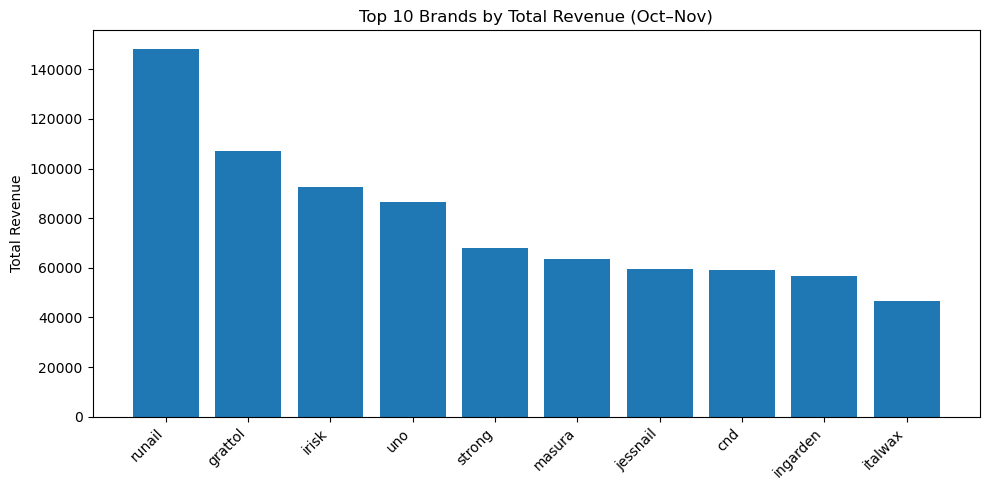

In [6]:
# CELL 4: Bar chart - total revenue by top brands

top_brands_pd = top_brands_df.limit(TOP_N_BRANDS).toPandas()

# Ensure no None values sneak into the plot
top_brands_pd = top_brands_pd[top_brands_pd["brand"].notna()]

plt.figure(figsize=(10, 5))
plt.bar(top_brands_pd["brand"].astype(str), top_brands_pd["total_revenue"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Revenue")
plt.title(f"Top {TOP_N_BRANDS} Brands by Total Revenue (Oct–Nov)")
plt.tight_layout()
plt.show()

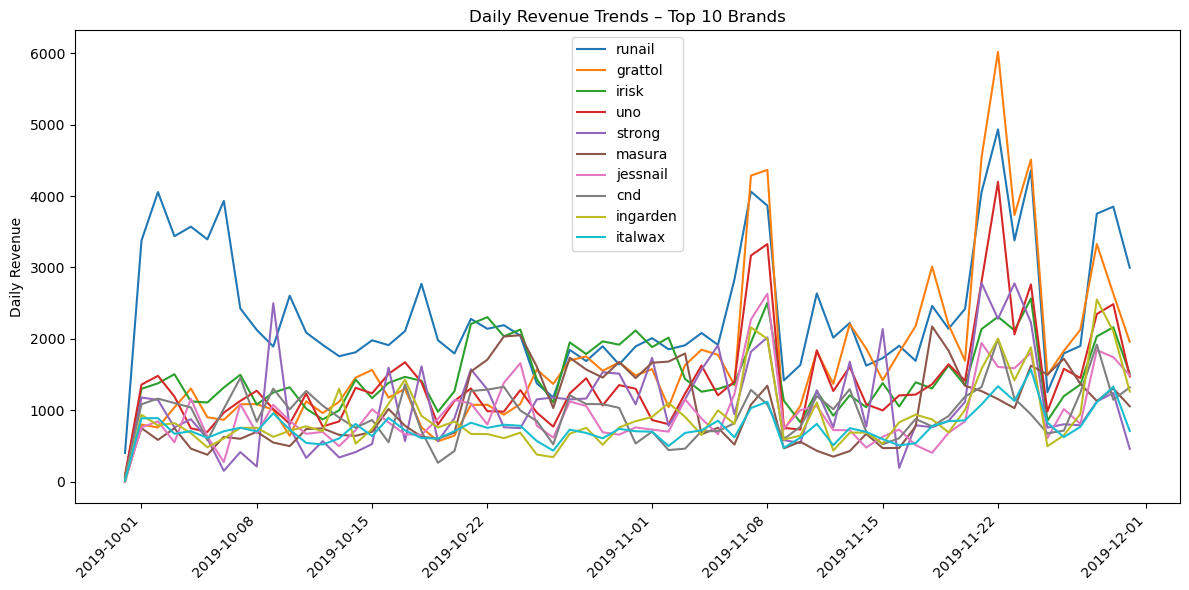

In [7]:
# CELL 5: Daily revenue trends for top brands

from pyspark.sql.functions import to_date

# Filter to top brands
daily_top = daily_brand.filter(col("brand").isin(top_brands))

# Convert to pandas for plotting
daily_top_pd = (
    daily_top
    .select("date", "brand", "revenue")
    .orderBy("date", "brand")
    .toPandas()
)

# Pivot to have one column per brand
pivot_rev = daily_top_pd.pivot(index="date", columns="brand", values="revenue")

plt.figure(figsize=(12, 6))
for brand in top_brands:
    if brand in pivot_rev.columns:
        plt.plot(pivot_rev.index, pivot_rev[brand], label=brand)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Daily Revenue")
plt.title(f"Daily Revenue Trends – Top {TOP_N_BRANDS} Brands")
plt.tight_layout()
plt.legend()
plt.show()

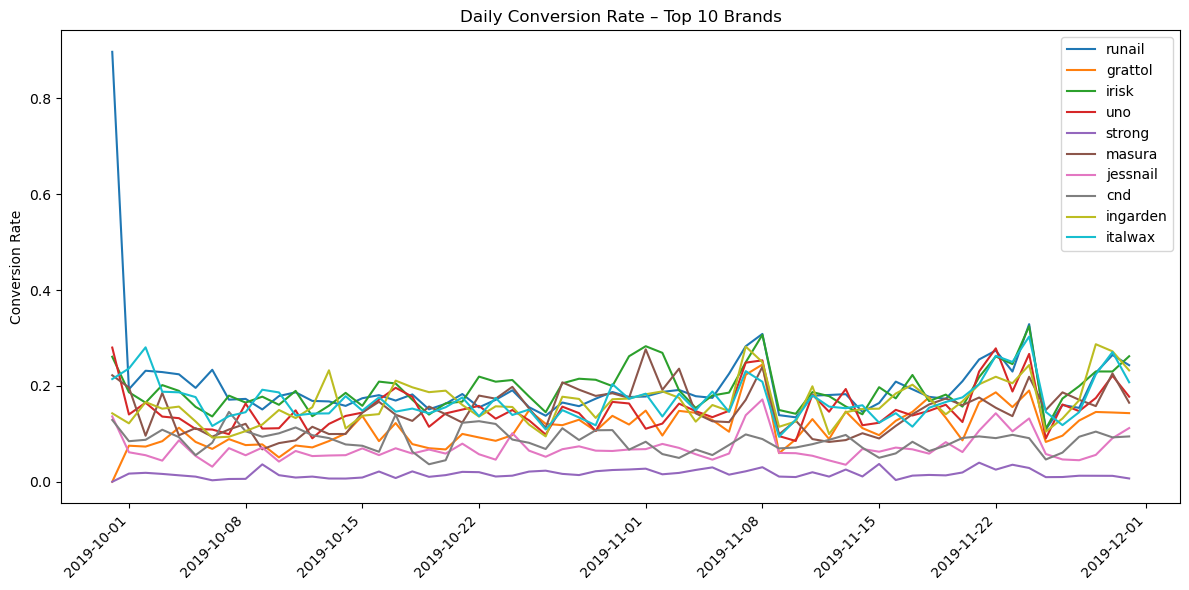

In [8]:
# CELL 6: Daily conversion rate for top brands

daily_conv_pd = (
    daily_top
    .select("date", "brand", "conversion_rate")
    .orderBy("date", "brand")
    .toPandas()
)

pivot_conv = daily_conv_pd.pivot(index="date", columns="brand", values="conversion_rate")

plt.figure(figsize=(12, 6))
for brand in top_brands:
    if brand in pivot_conv.columns:
        plt.plot(pivot_conv.index, pivot_conv[brand], label=brand)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Conversion Rate")
plt.title(f"Daily Conversion Rate – Top {TOP_N_BRANDS} Brands")
plt.tight_layout()
plt.legend()
plt.show()

Rows in gold_funnel_daily_category: 374


+-------------+------------------+-----------+---------------+
|category_root|total_revenue     |total_views|total_purchases|
+-------------+------------------+-----------+---------------+
|NULL         |2632126.2600000007|3832482    |560274         |
|appliances   |58724.40000000001 |46630      |1709           |
|furniture    |27299.89          |18040      |637            |
|apparel      |13189.819999999996|6729       |1841           |
|stationery   |6510.85           |8788       |2920           |
|accessories  |3901.3899999999994|11607      |133            |
|sport        |0.0               |2          |0              |
+-------------+------------------+-----------+---------------+



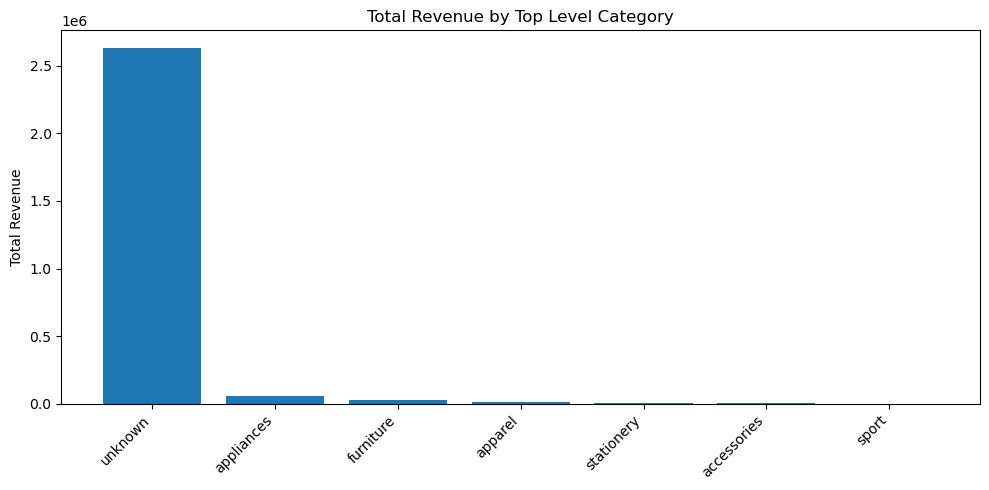

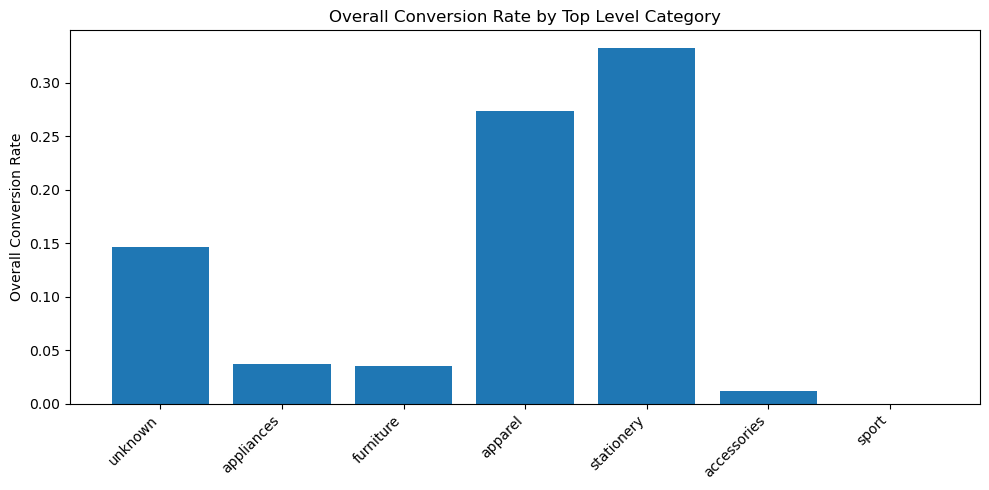

In [10]:
# CELL 7: Category-level performance (daily category gold)

from pyspark.sql.functions import sum as _sum, desc, col

daily_cat = spark.read.parquet(gold_daily_category_path)
print("Rows in gold_funnel_daily_category:", daily_cat.count())

# Aggregate across all days to find performance by category_root
cat_perf = (
    daily_cat
    .groupBy("category_root")
    .agg(
        _sum("revenue").alias("total_revenue"),
        _sum("views").alias("total_views"),
        _sum("purchases").alias("total_purchases")
    )
    .orderBy(desc("total_revenue"))
)

cat_perf.show(20, truncate=False)

cat_perf_pd = cat_perf.toPandas()

# Handle NULL category_root: treat it as "unknown"
cat_perf_pd["category_root"] = cat_perf_pd["category_root"].fillna("unknown").astype(str)

cat_perf_pd["overall_conversion_rate"] = (
    cat_perf_pd["total_purchases"] / cat_perf_pd["total_views"]
)

# Bar chart: revenue by category_root
plt.figure(figsize=(10, 5))
plt.bar(cat_perf_pd["category_root"], cat_perf_pd["total_revenue"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Revenue")
plt.title("Total Revenue by Top Level Category")
plt.tight_layout()
plt.show()

# Bar chart: overall conversion rate by category_root
plt.figure(figsize=(10, 5))
plt.bar(cat_perf_pd["category_root"], cat_perf_pd["overall_conversion_rate"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Overall Conversion Rate")
plt.title("Overall Conversion Rate by Top Level Category")
plt.tight_layout()
plt.show()

Rows in gold_funnel_hourly_price_band: 5856


+----------+-----------+---------------+------------------+
|price_band|total_views|total_purchases|total_revenue     |
+----------+-----------+---------------+------------------+
|10-30     |641640     |46885          |697043.4900000012 |
|30-60     |166164     |4159           |177654.54999999996|
|60_plus   |165696     |2131           |228124.9900000001 |
|<10       |2950778    |514339         |1638929.5800000008|
+----------+-----------+---------------+------------------+



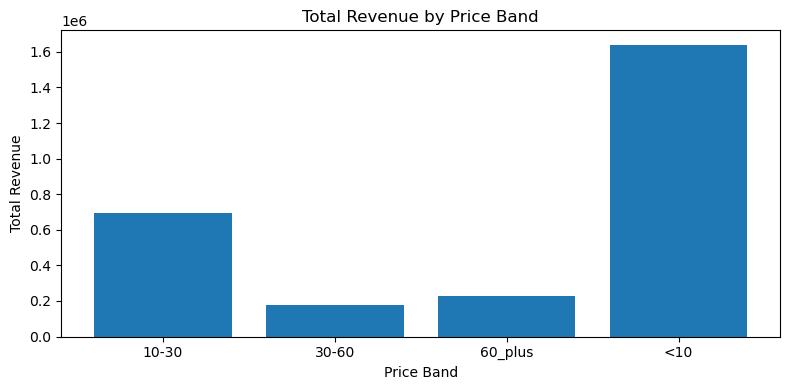

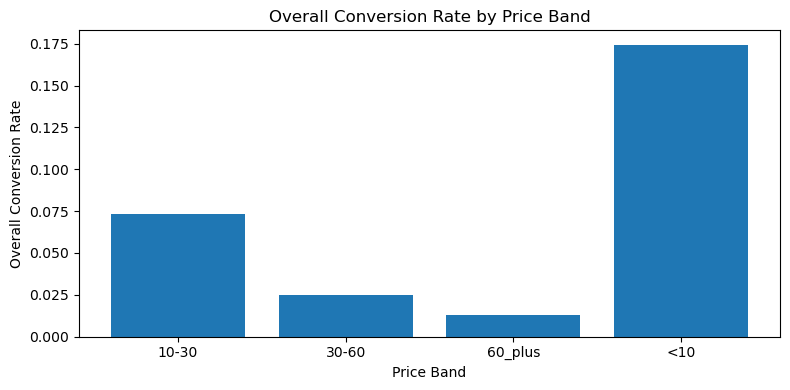

In [11]:
# CELL 8 (fixed): Price band behavior using hourly price gold

from pyspark.sql.functions import sum as _sum

hourly_price = spark.read.parquet(gold_hourly_price_path)
print("Rows in gold_funnel_hourly_price_band:", hourly_price.count())

price_perf = (
    hourly_price
    .groupBy("price_band")
    .agg(
        _sum("views").alias("total_views"),
        _sum("purchases").alias("total_purchases"),
        _sum("revenue").alias("total_revenue")
    )
    .orderBy("price_band")
)

price_perf.show(20, truncate=False)

price_perf_pd = price_perf.toPandas()

# Handle NULL price_band for plotting
price_perf_pd["price_band"] = price_perf_pd["price_band"].fillna("unknown").astype(str)

# Avoid division by zero
price_perf_pd["overall_conversion_rate"] = price_perf_pd.apply(
    lambda row: (row["total_purchases"] / row["total_views"]) if row["total_views"] > 0 else 0.0,
    axis=1
)

# Bar: total revenue by price_band
plt.figure(figsize=(8, 4))
plt.bar(price_perf_pd["price_band"], price_perf_pd["total_revenue"])
plt.xlabel("Price Band")
plt.ylabel("Total Revenue")
plt.title("Total Revenue by Price Band")
plt.tight_layout()
plt.show()

# Bar: overall conversion by price_band
plt.figure(figsize=(8, 4))
plt.bar(price_perf_pd["price_band"], price_perf_pd["overall_conversion_rate"])
plt.xlabel("Price Band")
plt.ylabel("Overall Conversion Rate")
plt.title("Overall Conversion Rate by Price Band")
plt.tight_layout()
plt.show()

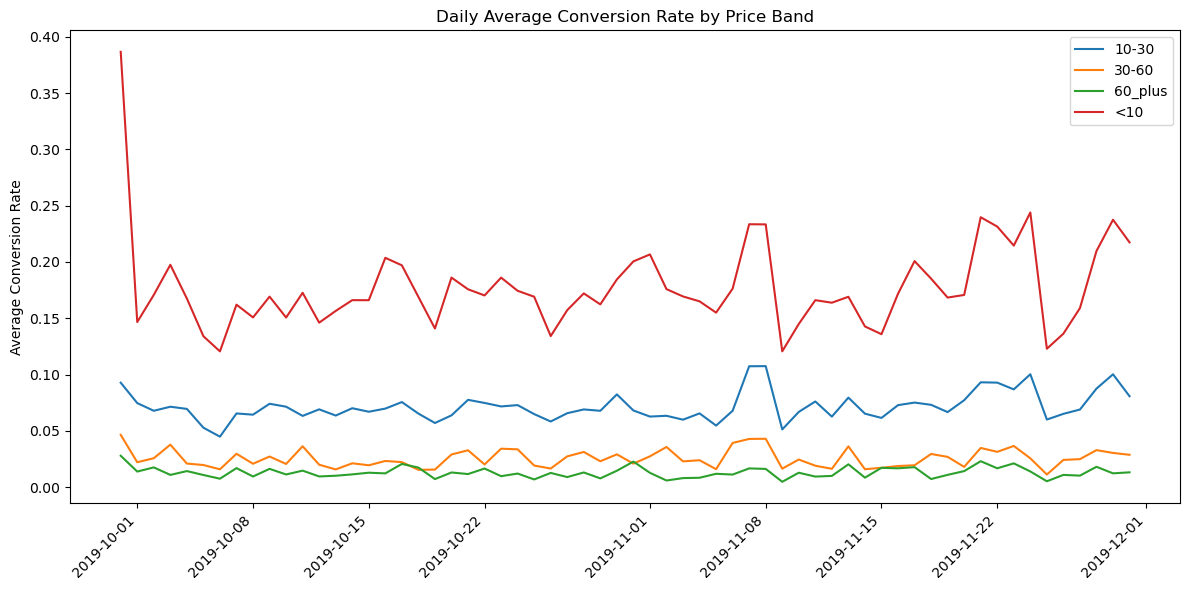

In [12]:
# OPTIONAL: Daily average conversion rate by price band over time

from pyspark.sql.functions import avg as _avg, to_date, col

# Use hourly_price from above
hourly_price_conv = (
    hourly_price
    .withColumn("window_date", to_date(col("window_start")))
    .groupBy("window_date", "price_band")
    .agg(
        _avg("conversion_rate").alias("avg_conversion_rate")
    )
)

hp_pd = (
    hourly_price_conv
    .toPandas()
)

if hp_pd.empty:
    print("No hourly price data for conversion by band.")
else:
    hp_pd["price_band"] = hp_pd["price_band"].fillna("unknown").astype(str)
    pivot_hp = hp_pd.pivot(index="window_date", columns="price_band", values="avg_conversion_rate")

    plt.figure(figsize=(12, 6))
    for band in pivot_hp.columns:
        plt.plot(pivot_hp.index, pivot_hp[band], label=str(band))

    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Average Conversion Rate")
    plt.title("Daily Average Conversion Rate by Price Band")
    plt.tight_layout()
    plt.legend()
    plt.show()

Rows in gold_anomalies_hourly_brand: 442


+-----------+------------+-------------+
|window_date|anomaly_type|num_anomalies|
+-----------+------------+-------------+
|2019-09-30 |spike       |1            |
|2019-10-01 |spike       |6            |
|2019-10-02 |spike       |3            |
|2019-10-03 |spike       |3            |
|2019-10-04 |drop        |1            |
|2019-10-04 |spike       |3            |
|2019-10-05 |spike       |3            |
|2019-10-06 |spike       |5            |
|2019-10-07 |spike       |3            |
|2019-10-08 |spike       |5            |
|2019-10-09 |spike       |3            |
|2019-10-10 |spike       |3            |
|2019-10-11 |spike       |4            |
|2019-10-12 |spike       |2            |
|2019-10-13 |spike       |5            |
|2019-10-14 |spike       |3            |
|2019-10-15 |spike       |7            |
|2019-10-16 |spike       |4            |
|2019-10-17 |spike       |7            |
|2019-10-18 |spike       |6            |
+-----------+------------+-------------+
only showing top

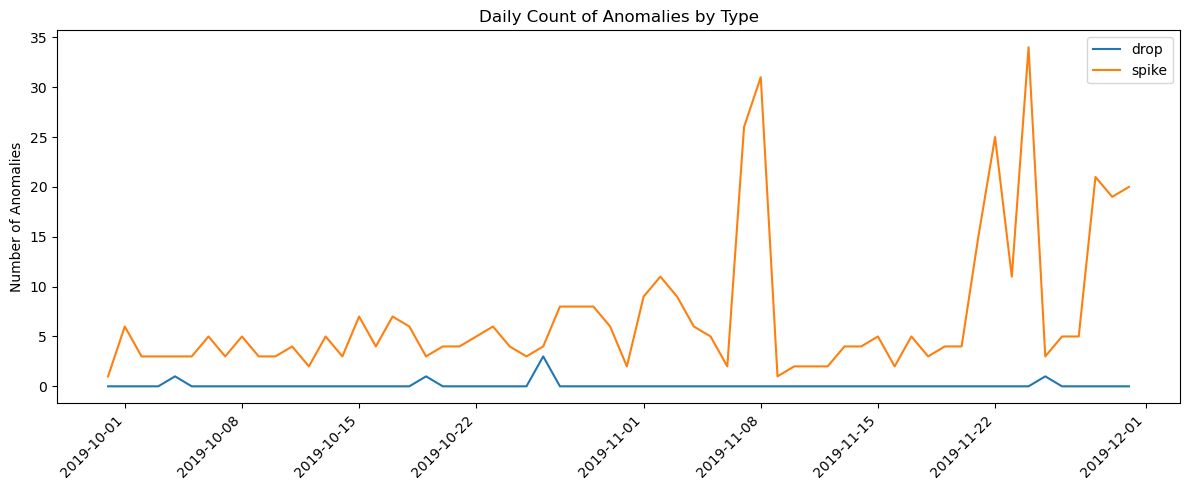

In [13]:
# CELL 9 (fixed): Anomaly counts over time

from pyspark.sql.functions import count, to_date, col

anoms = spark.read.parquet(anomaly_hourly_brand_path)
print("Rows in gold_anomalies_hourly_brand:", anoms.count())

if anoms.count() == 0:
    print("No anomalies found. Check Notebook 05.")
else:
    # Normalize anomaly_type for plotting
    anoms_clean = anoms.withColumn(
        "anomaly_type",
        col("anomaly_type").cast("string")
    )

    anoms_by_day = (
        anoms_clean
        .groupBy("window_date", "anomaly_type")
        .agg(count("*").alias("num_anomalies"))
        .orderBy("window_date", "anomaly_type")
    )

    anoms_by_day.show(20, truncate=False)

    anoms_by_day_pd = anoms_by_day.toPandas()
    anoms_by_day_pd["anomaly_type"] = anoms_by_day_pd["anomaly_type"].fillna("unknown").astype(str)

    pivot_anoms = (
        anoms_by_day_pd
        .pivot(index="window_date", columns="anomaly_type", values="num_anomalies")
        .fillna(0)
    )

    plt.figure(figsize=(12, 5))
    for col_name in pivot_anoms.columns:
        plt.plot(pivot_anoms.index, pivot_anoms[col_name], label=str(col_name))

    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of Anomalies")
    plt.title("Daily Count of Anomalies by Type")
    plt.tight_layout()
    plt.legend()
    plt.show()

Focus brand: runail


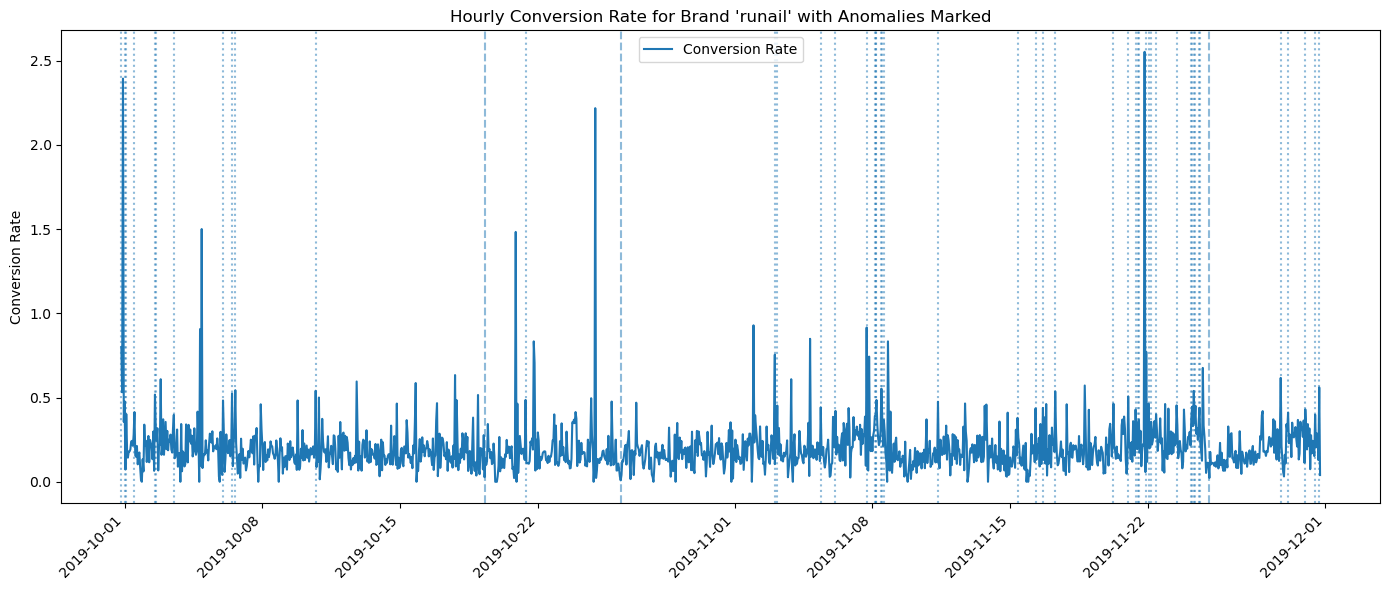

In [14]:
# CELL 10 (fixed): Deep dive on one brand - conversion vs anomalies

from pyspark.sql.functions import col

if len(top_brands) == 0:
    print("No top brands available to analyze. Skipping deep dive.")
else:
    focus_brand = top_brands[0]
    print("Focus brand:", focus_brand)

    hourly_brand = spark.read.parquet(gold_hourly_brand_path)

    hb_focus = (
        hourly_brand
        .filter(col("brand") == focus_brand)
        .select("window_start", "window_date", "conversion_rate", "views", "purchases")
        .orderBy("window_start")
    )

    if hb_focus.count() == 0:
        print(f"No hourly funnel data available for brand '{focus_brand}'.")
    else:
        hb_focus_pd = hb_focus.toPandas()

        anoms_focus = (
            anoms
            .filter(col("brand") == focus_brand)
            .select("window_start", "anomaly_type", "z_brand", "z_brand_hour")
            .orderBy("window_start")
        )

        anoms_focus_pd = anoms_focus.toPandas()
        anoms_focus_pd["anomaly_type"] = anoms_focus_pd["anomaly_type"].fillna("unknown").astype(str)

        plt.figure(figsize=(14, 6))
        plt.plot(hb_focus_pd["window_start"], hb_focus_pd["conversion_rate"], label="Conversion Rate")

        # Overlay anomalies if they exist
        drop_times = anoms_focus_pd[anoms_focus_pd["anomaly_type"] == "drop"]["window_start"]
        spike_times = anoms_focus_pd[anoms_focus_pd["anomaly_type"] == "spike"]["window_start"]

        for t in drop_times:
            plt.axvline(t, linestyle="--", alpha=0.5)
        for t in spike_times:
            plt.axvline(t, linestyle=":", alpha=0.5)

        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Conversion Rate")
        plt.title(f"Hourly Conversion Rate for Brand '{focus_brand}' with Anomalies Marked")
        plt.tight_layout()
        plt.legend()
        plt.show()